# ImageNet Fine Tuning Binary Classification on Low and High Classes
This experiment will involve classifying high- and low-quality images using a pretrained Xception model to test performance on classifying the two extreme classes.

## Setup

In [1]:
!nvidia-smi

Sat Sep 28 00:40:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B2:00.0 Off |                    0 |
| N/A   32C    P0             41W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeable
  Using cached nvidia_cublas_cu12-12.3.4.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.3.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.3.107-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.3.101-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.7.29-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.12.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.4.107-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.5.4.101-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.2.0.103-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl.m

In [4]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-09-28 00:42:00.093606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 00:42:00.111378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 00:42:00.128323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 00:42:00.133190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 00:42:00.145735: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [7]:
import numpy as np
import keras
import keras_cv
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

In [8]:
!pwd
!ls koa_scratch

/home/jctactay/photograding/quality
ls: cannot access 'koa_scratch': No such file or directory


## Data preprocessing

In [11]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('/home/jctactay/photograding/pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('/home/jctactay/photograding/pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)
target_labels = ["high", "low"]

In [12]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
print(len(labels.image))

3586


In [13]:
# remove medium-quality images
labels = labels.drop(labels[labels.quality == 2].index)
print(len(labels.image))

2107


In [14]:
# adjust labels to be binary
for index, row in labels.iterrows():
    if row.quality == 3:
       labels.at[index, 'quality'] = 2

In [15]:
paths = []
for index, row in labels.iterrows():
    paths.append("/home/jctactay/koa_scratch/images/" + row.image)
assert len(labels) == len(paths)

In [16]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict():
    imgs = {}

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()

imgs = load_images_into_dict()
print(f"Done in {time() - t0: .3f}s")

Done in  86.405s


In [17]:
value_counts = labels.quality.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

quality
1    1116
2     991
Name: count, dtype: int64

In [18]:
print(labels)

                       species                           image  \
0              spinner_dolphin              0011f7a65044e4.jpg   
2              spinner_dolphin              009a307f9f483c.jpg   
3              spinner_dolphin              00eea1a5b9d8bc.jpg   
4              spinner_dolphin              01287e826d29a8.jpg   
10    short_finned_pilot_whale              0246806606bc80.jpg   
...                        ...                             ...   
3587        melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg   
3588        melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg   
3589        melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg   
3590        melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg   
3591        melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg   

      distinctiveness  quality  
0                 2.0        2  
2                 2.0        1  
3                 2.0        1  
4                 2.0        1  
10                2.0        1  
...      

In [19]:
assert len(imgs) == len(labels)

In [20]:
# readjust labels to range of [0,1]
Y = labels.quality
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([imgs[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1]
2107
2107


In [21]:
print(len(X_train), len(X_val), len(X_test))

1263 422 422


In [22]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[0.94394619 1.06313131]


array([0.94394619, 1.06313131, 0.94394619, ..., 0.94394619, 0.94394619,
       1.06313131])

In [23]:
def augment_image(image, label, weight):
    image = augmentation_layers(image)
    if tf.math.reduce_any(tf.equal(label, 2)):
        image = poor_augmentation_layers(image)
    return image, label, weight

In [24]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=42)
])

poor_augmentation_layers = keras.Sequential([
    keras.layers.RandomRotation(factor=0.1, seed=42),
    # keras_cv.layers.RandomSharpness(factor=0.2, value_range=[0,1], seed=42),
    keras.layers.RandomFlip(mode="vertical", seed=42),
    # keras_cv.layers.RandomSaturation(factor=(0.0, 0.5), seed=42)
])

2024-09-28 00:44:33.846243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [25]:
t0 = time()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, sample_weights))
# controls augmentation
# train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print("Done in %0.3fs" % (time() - t0))

Done in 1.070s


## Visualize augmentations

In [26]:
# Inspect the structure of the dataset
for batch in train_dataset.take(1):
    print("Batch structure:")
    for element in batch:
        print(f"Element shape: {element.shape}")
        print(f"Element type: {type(element)}")

Batch structure:
Element shape: (32, 128, 128, 3)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>


2024-09-28 00:44:35.385207: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


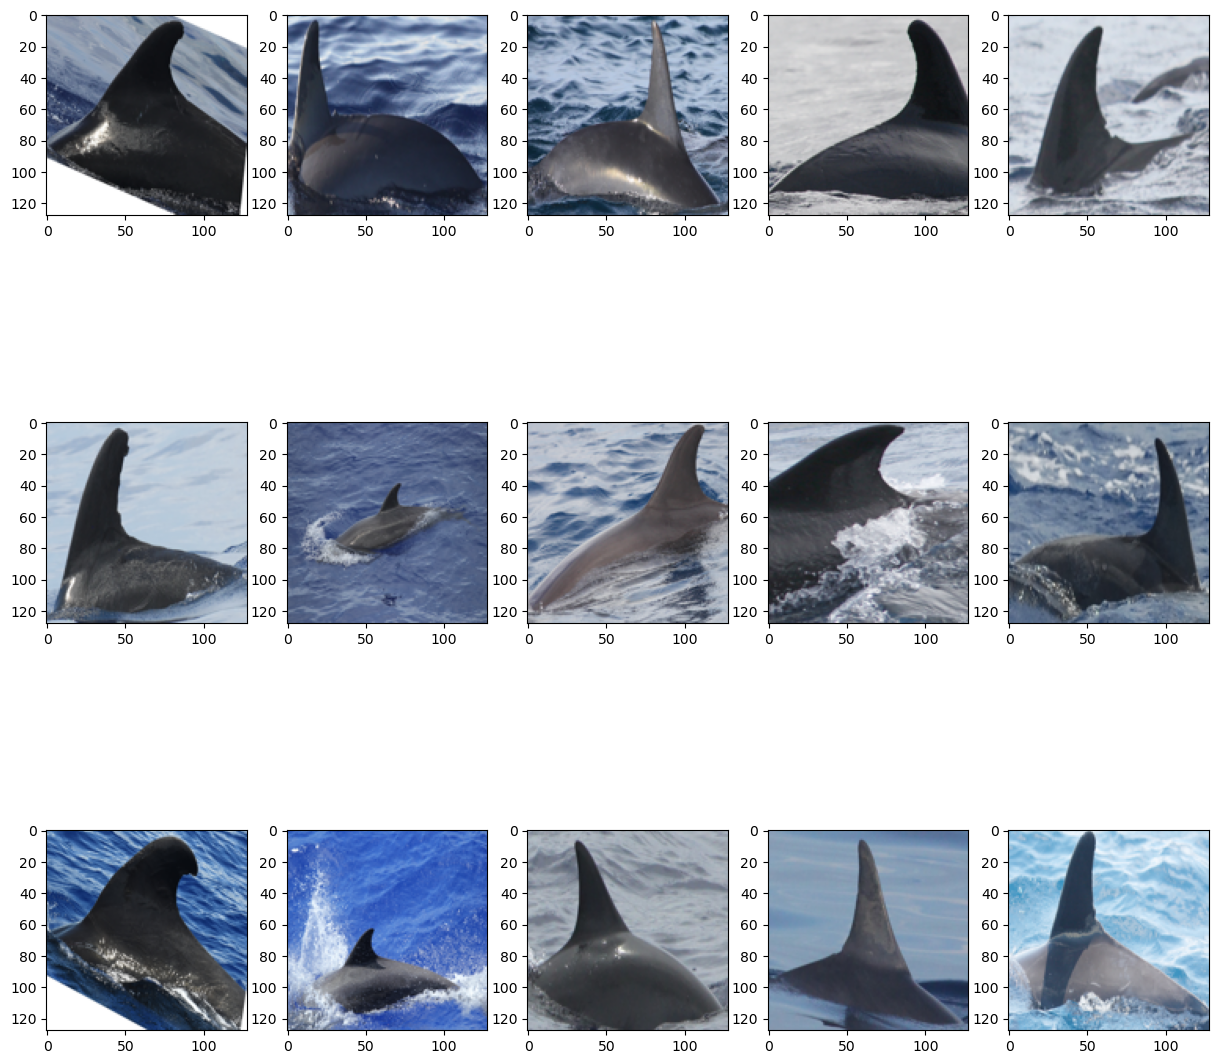

2024-09-28 00:44:36.934767: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
def visualize_augmentation(dataset, num_images=15):
    for batch in dataset.take(1):  # Take one batch
        images, _, _ = batch
        plt.figure(figsize=(15, 15))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 5, i + 1)
            image = images[i].numpy()
            image = (image + 1) / 2
            plt.imshow(image)
        plt.show()

# Visualize augmented images
visualize_augmentation(train_dataset)

## Model

In [35]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

In [36]:
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer_2… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d_4[0][0] │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_12 (Add)      │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add_12[0][0]   │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [37]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
# x = augmentation_layers(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [38]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

In [39]:
def predict(dataset, pred_model):
    true = []
    preds = []
    for images, labels in dataset:
        pred_soft = pred_model.predict(images)
        pred = np.round(pred_soft)
        true.extend(labels.numpy())
        preds.extend(pred)
    return true, preds

## Initial fit

In [40]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [42]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=callback)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.7222 - loss: 2.5919 - val_accuracy: 0.6777 - val_loss: 1.3623
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7337 - loss: 1.2277 - val_accuracy: 0.7251 - val_loss: 1.0474
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7273 - loss: 1.0250 - val_accuracy: 0.6611 - val_loss: 1.0111
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7479 - loss: 0.8519 - val_accuracy: 0.6919 - val_loss: 0.8581
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7762 - loss: 0.7092 - val_accuracy: 0.6848 - val_loss: 0.7998
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7577 - loss: 0.6878 - val_accuracy: 0.6943 - val_loss: 0.7643
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7821 - loss: 0.6263 - val_accuracy: 0.7393 - val_loss: 0.6710
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7870 - loss: 0.5954 - val_accuracy: 0.6943 -

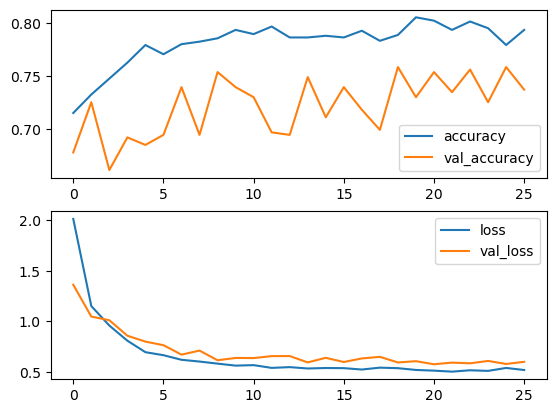

In [43]:
plot_history(history)

In [44]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7643 - loss: 0.5316
test loss, test acc: [0.5322404503822327, 0.7748815417289734]


In [45]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [46]:
print(classification_report(true, pred, target_names=target_labels))

              precision    recall  f1-score   support

        high       0.78      0.81      0.79       224
         low       0.77      0.74      0.75       198

    accuracy                           0.77       422
   macro avg       0.77      0.77      0.77       422
weighted avg       0.77      0.77      0.77       422



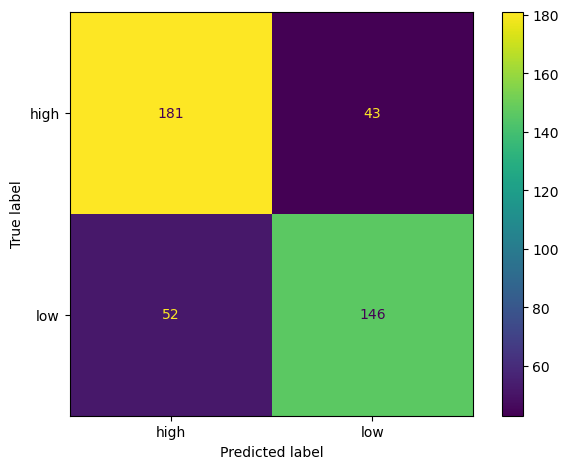

In [47]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot()
plt.tight_layout()

## Top 4 layers

In [48]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 27,159,085 (103.60 MB)

 Trainable params: 5,262,849 (20.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 4,198,404 (16.02 MB)

In [49]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [50]:
# top 4 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/20


E0000 00:00:1727484404.827786   78875 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727484405.002378   78875 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8019 - loss: 0.5561

E0000 00:00:1727484409.084681   78875 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727484409.259146   78875 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.8024 - loss: 0.5556 - val_accuracy: 0.7701 - val_loss: 0.5732
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8191 - loss: 0.5315 - val_accuracy: 0.7749 - val_loss: 0.5723
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8315 - loss: 0.5193 - val_accuracy: 0.7749 - val_loss: 0.5724
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8413 - loss: 0.5018 - val_accuracy: 0.7701 - val_loss: 0.5712
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8439 - loss: 0.4859 - val_accuracy: 0.7701 - val_loss: 0.5704
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8388 - loss: 0.4792 - val_accuracy: 0.7701 - val_loss: 0.5687
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8513 - loss: 0.4754 - val_accuracy: 0.7701 - val_loss: 0.5663
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8472 - loss: 0.4634 - val_accuracy: 0.7749 - val_loss:

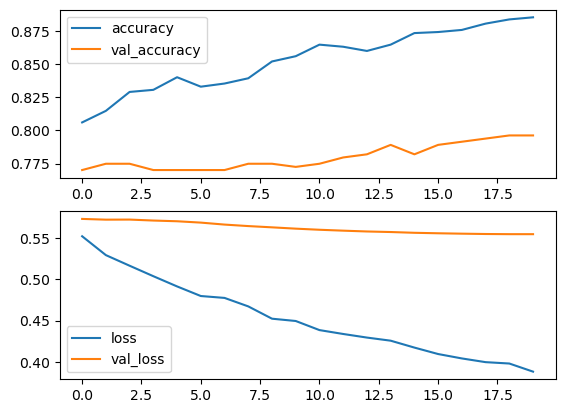

In [51]:
plot_history(history)

In [52]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-09-28 00:47:42.635041: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       224
           1       0.79      0.78      0.79       198

    accuracy                           0.80       422
   macro avg       0.80      0.80      0.80       422
weighted avg       0.80      0.80      0.80       422



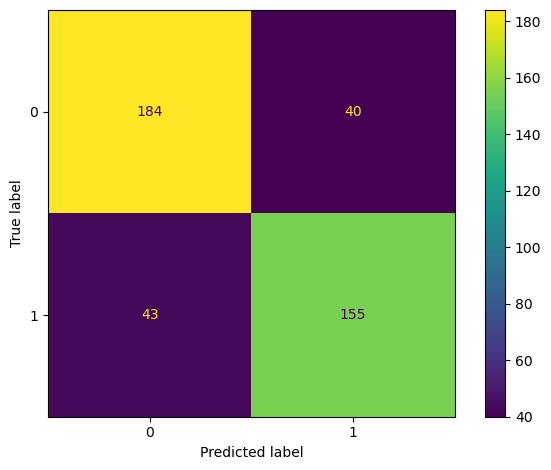

In [54]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [55]:
# model.save("4-layers-big-binary.keras")

## Top 8 layers

In [56]:
# unfreeze top 8 base layers
for layer in base_model.layers[-8:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 33,486,381 (127.74 MB)

 Trainable params: 6,850,049 (26.13 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

 Optimizer params: 10,525,700 (40.15 MB)

In [57]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [58]:
# top 8 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.6682 - loss: 0.6672 - val_accuracy: 0.7796 - val_loss: 0.5641
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7749 - loss: 0.6218 - val_accuracy: 0.7796 - val_loss: 0.5521
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8045 - loss: 0.5905 - val_accuracy: 0.7796 - val_loss: 0.5432
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8404 - loss: 0.5563 - val_accuracy: 0.7844 - val_loss: 0.5365
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8623 - loss: 0.5212 - val_accuracy: 0.7986 - val_loss: 0.5320
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8715 - loss: 0.4931 - val_accuracy: 0.8033 - val_loss: 0.5295
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8910 - loss: 0.4597 - val_accuracy: 0.8057 - val_loss: 0.5262
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8921 - loss: 0.4339 - val_accuracy: 0.8057 

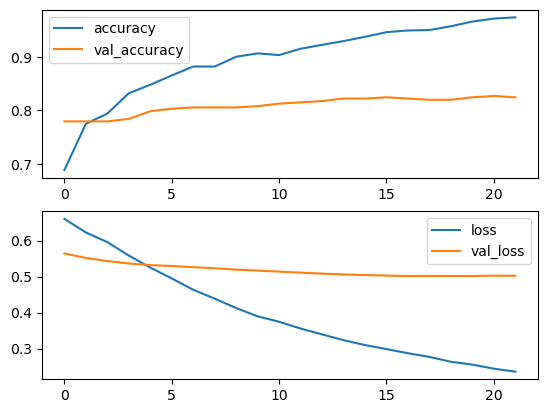

In [59]:
plot_history(history)

In [60]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [61]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       224
           1       0.79      0.81      0.80       198

    accuracy                           0.81       422
   macro avg       0.81      0.81      0.81       422
weighted avg       0.81      0.81      0.81       422



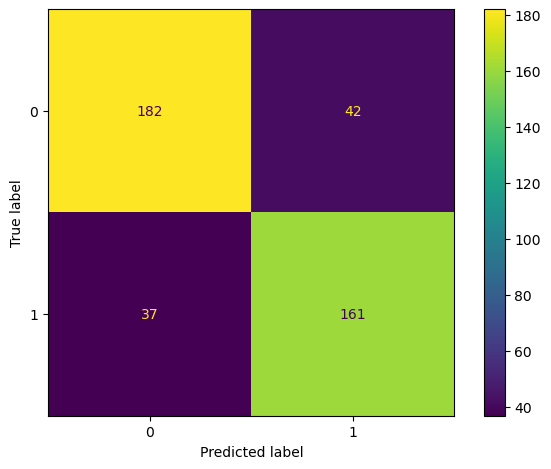

In [62]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [63]:
# model.save("8-layers-big-binary.keras")

## Top 10 layers

In [64]:
for layer in base_model.layers[-10:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 36,660,781 (139.85 MB)

 Trainable params: 7,595,521 (28.97 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

 Optimizer params: 13,700,100 (52.26 MB)

In [65]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=15)

In [66]:
# top 10 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=60
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.9543 - loss: 0.2703 - val_accuracy: 0.8246 - val_loss: 0.4999
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9615 - loss: 0.2606 - val_accuracy: 0.8223 - val_loss: 0.5000
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9666 - loss: 0.2531 - val_accuracy: 0.8270 - val_loss: 0.4998
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9702 - loss: 0.2444 - val_accuracy: 0.8318 - val_loss: 0.4998
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9774 - loss: 0.2380 - val_accuracy: 0.8294 - val_loss: 0.5001
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9769 - loss: 0.2327 - val_accuracy: 0.8294 - val_loss: 0.5000
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9815 - loss: 0.2251 - val_accuracy: 0.8341 - val_loss: 0.5004
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9809 - loss: 0.2217 - val_accuracy: 0.8270 

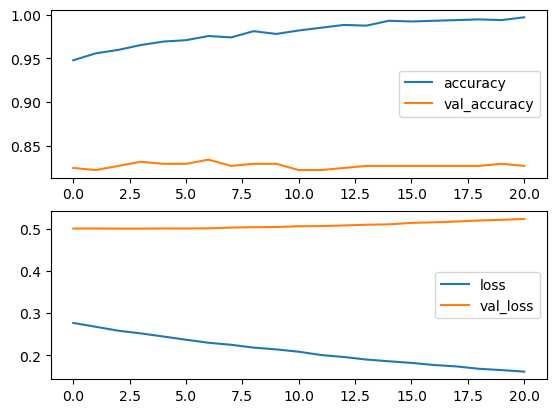

In [67]:
plot_history(history)

In [68]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [69]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       224
           1       0.82      0.83      0.83       198

    accuracy                           0.84       422
   macro avg       0.84      0.84      0.84       422
weighted avg       0.84      0.84      0.84       422



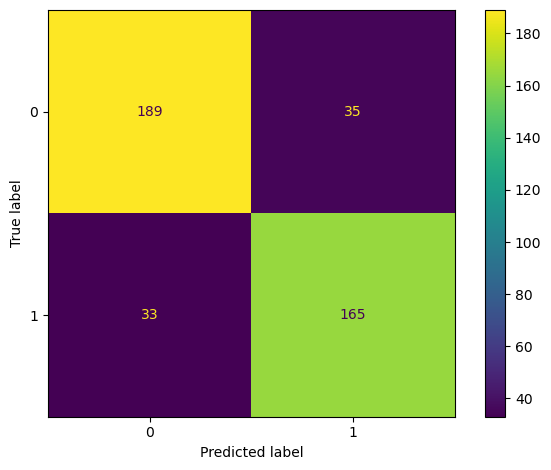

In [70]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [71]:
# model.save("10-layers-big-binary.keras")

## Analysis

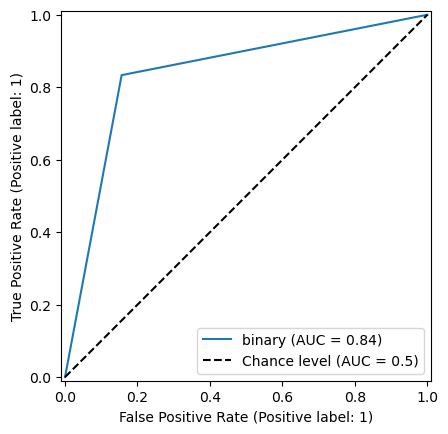

In [72]:
disp = RocCurveDisplay.from_predictions(true, pred, name="binary", plot_chance_level=True)
# plt.plot([0, 1], [0, 1], color='k', linestyle='--')

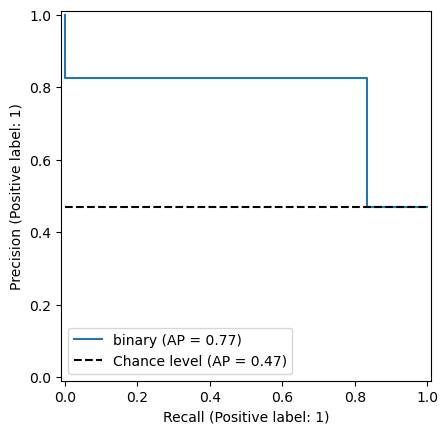

In [73]:
disp = PrecisionRecallDisplay.from_predictions(true, pred, name="binary", plot_chance_level=True)

2024-09-28 00:53:31.656173: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
198


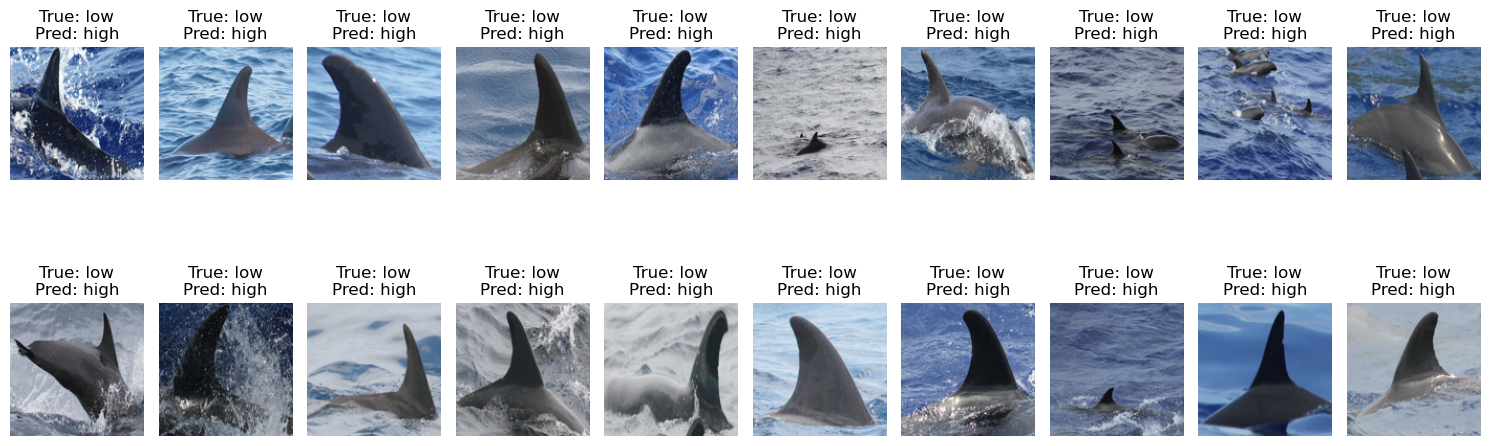

In [75]:
import random
images = []
labels = []
for batch in test_dataset:
    image_batch, label_batch = batch
    images.append((image_batch.numpy() + 1) * 127.5)
    labels.append(label_batch.numpy())
X_test = np.concatenate(images)
y_test = np.concatenate(labels)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = ['high', 'low'] 

incorrect_indices = np.where(y_pred != y_test)[0]
print(len(incorrect_indices))

subset_size = 20
n_cols = 10
n_rows = subset_size // n_cols + 1 * (subset_size % n_cols)

subset_indices = random.sample(list(incorrect_indices), min(subset_size, len(incorrect_indices)))

plt.figure(figsize=(15, 6))

for i, incorrect in enumerate(subset_indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(X_test[incorrect].astype('uint8'))  # Assuming images are normalized
    plt.title(f"True: {class_names[y_test[incorrect]]}\nPred: {class_names[y_pred[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

